# Making KGs from LLMs

LLM's can understand structured input and output. Especially larger models are able to understand properties and relationships between properties and express them in a structured output. In this tutorial we will see `LLMGraphTransformer`, a LangChain tool that allows the extraction of properties and relationships from free text.

We will visualize and interact with the resulting graphs using graph-related tools in python. We will use a text that presents some relationships between objects clearly, so that we can clearly observe the level of success.

In [1]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
import os

### Visualization functions

First let's define some convenience visualization functions that will allow us to view the generated graphs inside the notebook, and also allow us to interact with them in separate html files.

In [2]:
# Display graph using NetworkX and Matplotlib inside the notebook

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Convert graph documents to NetworkX graph
def create_image_graph(graph_docs, title="Knowledge Graph", path="figs/knowledge_graph.png"):
    G = nx.DiGraph()

    for doc in graph_docs:
        for node in doc.nodes:
            G.add_node(node.id, label=node.type)
        for rel in doc.relationships:
            G.add_edge(rel.source.id, rel.target.id, label=rel.type)

    # Get connected components (treating as undirected to find connected parts)
    G_undirected = G.to_undirected()
    components = list(nx.connected_components(G_undirected))

    # Position each component separately
    pos = {}
    x_offset = 0
    for component in components:
        # Create subgraph for this component
        subgraph = G.subgraph(component)
        # Layout this component
        component_pos = nx.nx_agraph.graphviz_layout(subgraph, prog="dot")
        
        # Shift component positions to avoid overlap
        for node, (x, y) in component_pos.items():
            pos[node] = (x + x_offset, y)
        
        # Offset for next component
        x_offset += 3

    # Visualize as static image
    plt.figure(figsize=(16, 10))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7)

    os.makedirs('figs', exist_ok=True)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches='tight')
    plt.show()

In [3]:
# Create interactive graph and save to html document using Pyvis

from pyvis.network import Network

def create_html_graph(graph_docs, path='html/knowledge_graph.html'):
    # Create Pyvis network
    net = Network(directed=True, notebook=True, height="750px", width="100%")

    # Add nodes and edges from graph documents
    for doc in graph_docs:
        for node in doc.nodes:
            net.add_node(node.id, label=node.id, title=f"Type: {node.type}")
        for rel in doc.relationships:
            # Ensure source and target nodes exist
            try:
                if not net.get_node(rel.source.id):
                    net.add_node(rel.source.id, label=rel.source.id, title="Inferred Node")
            except KeyError:
                net.add_node(rel.source.id, label=rel.source.id, title="Inferred Node")
            try:
                if not net.get_node(rel.target.id):
                    net.add_node(rel.target.id, label=rel.target.id, title="Inferred Node")
            except KeyError:
                net.add_node(rel.target.id, label=rel.target.id, title="Inferred Node")
            net.add_edge(
                rel.source.id,
                rel.target.id,
                label=rel.type
            )

    os.makedirs('html', exist_ok=True)

    # Customize physics
    net.show_buttons(filter_=['physics'])
    net.save_graph(path)

### Example text

Let's consider a straightforward text as an example, with entities and relations that are clear to us, so that we can identify the modes of failure and how each step that we take brings us closer to capturing as much of the structure as possible.

In [4]:
text = '''
The solar system consists of the Sun and the objects that orbit it, including planets, moons, asteroids, comets, and meteoroids.
The Sun is a star at the center of the Solar System.
Mercury is a planet in the Solar System. Mercury orbits the Sun. Mercury has no atmosphere and no magnetic field.
Venus is a planet in the Solar System. Venus orbits the Sun. Venus has a thick atmosphere. The atmosphere of Venus is composed mainly of carbon dioxide. Venus has no magnetic field.
Earth is a planet in the Solar System. Earth orbits the Sun. Earth has one moon called the Moon. Earth has a thick atmosphere composed mainly of nitrogen and oxygen. Earth has a strong magnetic field.
Mars is a planet in the Solar System. Mars orbits the Sun. Mars has two moons called Phobos and Deimos. Mars has a thin atmosphere composed mainly of carbon dioxide. Mars has a weak magnetic field.
Jupiter is a planet in the Solar System. Jupiter orbits the Sun. Jupiter has moons called Io, Europa, Ganymede, and Callisto. Jupiter has a thick atmosphere composed mainly of hydrogen and helium. Jupiter has a strong magnetic field.
'''
print(text)


The solar system consists of the Sun and the objects that orbit it, including planets, moons, asteroids, comets, and meteoroids.
The Sun is a star at the center of the Solar System.
Mercury is a planet in the Solar System. Mercury orbits the Sun. Mercury has no atmosphere and no magnetic field.
Venus is a planet in the Solar System. Venus orbits the Sun. Venus has a thick atmosphere. The atmosphere of Venus is composed mainly of carbon dioxide. Venus has no magnetic field.
Earth is a planet in the Solar System. Earth orbits the Sun. Earth has one moon called the Moon. Earth has a thick atmosphere composed mainly of nitrogen and oxygen. Earth has a strong magnetic field.
Mars is a planet in the Solar System. Mars orbits the Sun. Mars has two moons called Phobos and Deimos. Mars has a thin atmosphere composed mainly of carbon dioxide. Mars has a weak magnetic field.
Jupiter is a planet in the Solar System. Jupiter orbits the Sun. Jupiter has moons called Io, Europa, Ganymede, and Callis

### Model

While theoretically we could use any available model, better results are obtained with models that can handle structured output like JSON and Cypher (the language used in Neo4j for creating knowledge graph - we will have a look at it in the next tutorial). LLMs that are commercial do mostly come with those attributes already baked in. For this example, we will use a significantly smaller LLM that is, however, fine tuned for producing the required structured output.

In [5]:
# A model that is fine tuned to generate Cypher queries
model_name = 'tomasonjo/llama3-text2cypher-demo:8b_4bit'
# A non fine tuned model
# model_name = 'llama3.2:3b' # results from this model will be worse

# and initialize the ChatOllama instance
chat_model = ChatOllama(
    model=model_name,
    validate_model_on_init=True,
    temperature=0
)

In [6]:
documents = [Document(page_content=text)]
print(documents)

[Document(metadata={}, page_content='\nThe solar system consists of the Sun and the objects that orbit it, including planets, moons, asteroids, comets, and meteoroids.\nThe Sun is a star at the center of the Solar System.\nMercury is a planet in the Solar System. Mercury orbits the Sun. Mercury has no atmosphere and no magnetic field.\nVenus is a planet in the Solar System. Venus orbits the Sun. Venus has a thick atmosphere. The atmosphere of Venus is composed mainly of carbon dioxide. Venus has no magnetic field.\nEarth is a planet in the Solar System. Earth orbits the Sun. Earth has one moon called the Moon. Earth has a thick atmosphere composed mainly of nitrogen and oxygen. Earth has a strong magnetic field.\nMars is a planet in the Solar System. Mars orbits the Sun. Mars has two moons called Phobos and Deimos. Mars has a thin atmosphere composed mainly of carbon dioxide. Mars has a weak magnetic field.\nJupiter is a planet in the Solar System. Jupiter orbits the Sun. Jupiter has m

### No schema

First let's attempt to make the KG directly from the text, without providing the model with any information about what the nodes or edges are expected to be - i.e., provide no schema.

In [7]:
no_schema = LLMGraphTransformer(
    llm=chat_model
)
graph_no_schema = no_schema.convert_to_graph_documents(documents)

In [8]:
print(graph_no_schema)
print(f"Nodes: {graph_no_schema[0].nodes}")
print(f"Relationships: {graph_no_schema[0].relationships}")

[GraphDocument(nodes=[Node(id='Sun', type='Star', properties={}), Node(id='Mercury', type='Planet', properties={}), Node(id='Venus', type='Planet', properties={}), Node(id='Earth', type='Planet', properties={}), Node(id='Mars', type='Planet', properties={}), Node(id='Jupiter', type='Planet', properties={}), Node(id='Moon', type='Moon', properties={}), Node(id='Phobos', type='Moon', properties={}), Node(id='Deimos', type='Moon', properties={}), Node(id='Io', type='Moon', properties={}), Node(id='Europa', type='Moon', properties={}), Node(id='Ganymede', type='Moon', properties={}), Node(id='Callisto', type='Moon', properties={})], relationships=[Relationship(source=Node(id='Mercury', type='Planet', properties={}), target=Node(id='Sun', type='Star', properties={}), type='ORBITS', properties={}), Relationship(source=Node(id='Venus', type='Planet', properties={}), target=Node(id='Sun', type='Star', properties={}), type='ORBITS', properties={}), Relationship(source=Node(id='Earth', type='Pla

### Results without schema

We observe that the model is doing a good job in capturing relations between the sun, planets and their moons. The model has missed details like the existance of atmposphere or magnetic field in planets. We can introduce such information by clarifying what the schema should be.

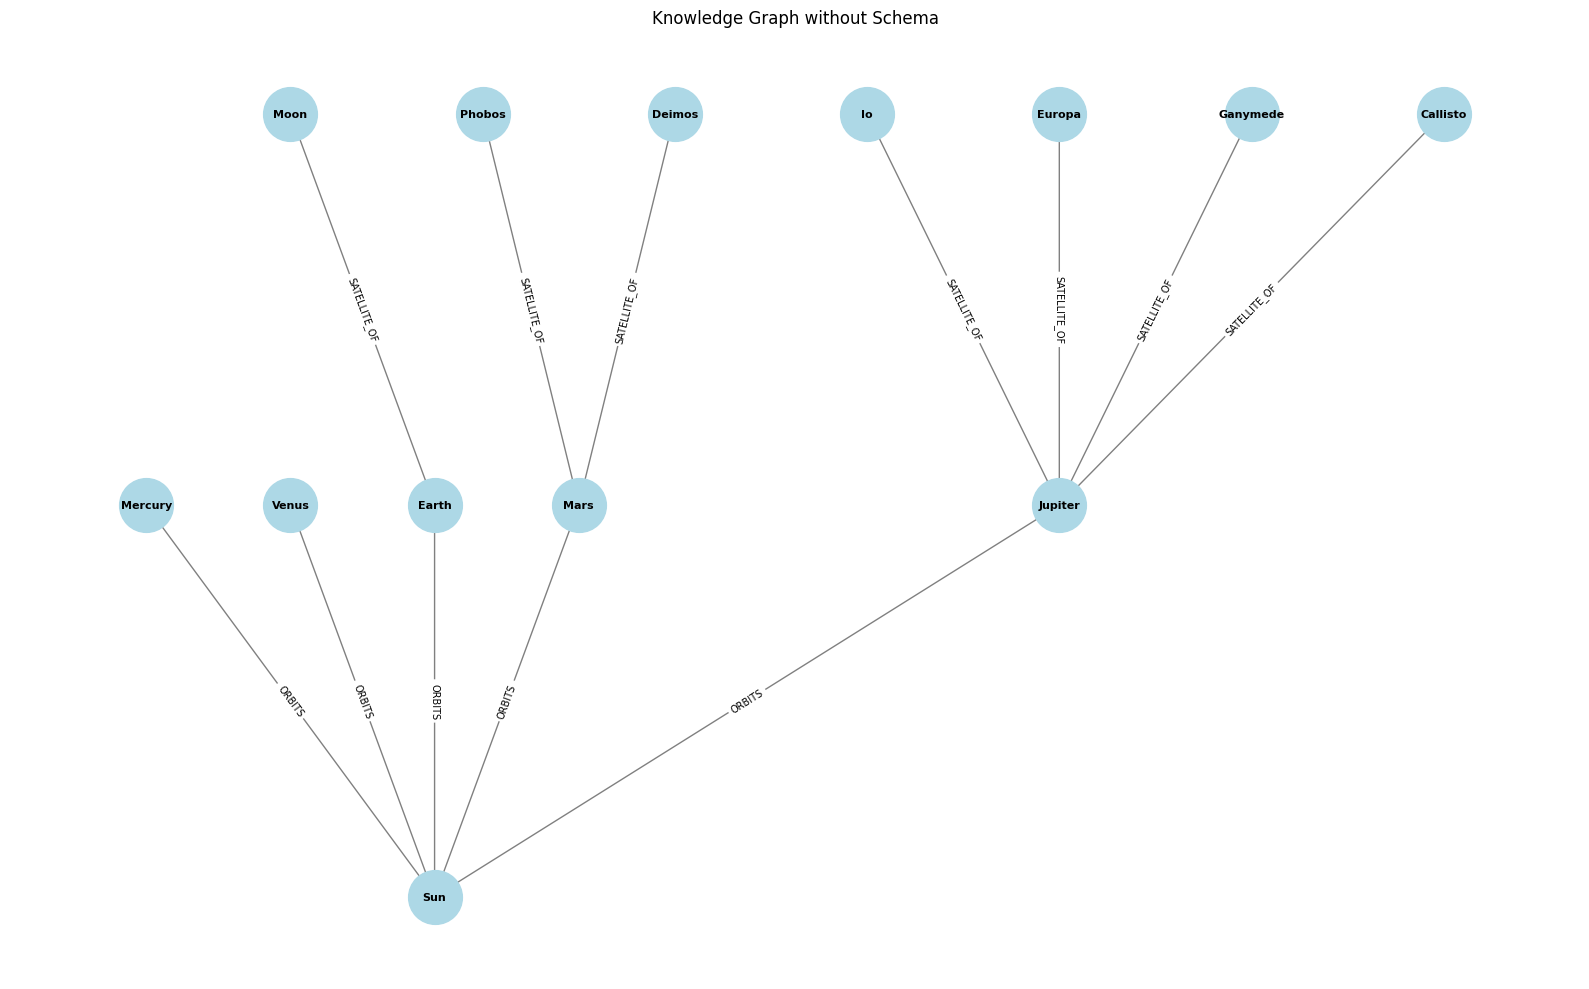

In [9]:
create_image_graph(graph_no_schema, title="Knowledge Graph without Schema", path="figs/knowledge_graph_no_schema.png")
create_html_graph(graph_no_schema, path='html/knowledge_graph_no_schema.html')

### Introduce a schema with lists

LangChain allows to inform the model about what we expect from it when it comes to identified nodes and edges. We can introduce `allowed_nodes` and `allowed_relationships` when initializing an `LLMGraphTransformer`, but as we will see in a while, this does not always work well - especially with small models like the one we are using.

In [10]:
allowed_nodes = [
    "Star",
    "Planet",
    "Moon",
    "Atmosphere",
    "Substance",
    "MagneticField"
]

allowed_relationships = [
    ("Planet", "ORBITS", "Star"),
    ("Moon", "ORBITS", "Planet"),
    ("Planet", "HAS_ATMOSPHERE", "Atmosphere"),
    ("Atmosphere", "COMPOSED_OF", "Substance"),
    ("Planet", "HAS_MAGNETIC_FIELD", "MagneticField"),
]

In [11]:
list_schema = LLMGraphTransformer(
    llm=chat_model,
    allowed_nodes=allowed_nodes,
    allowed_relationships=allowed_relationships,
)

graph_list_schema = list_schema.convert_to_graph_documents(documents)

### Lists failure

We can see that the model was not helped at all by the lists with allowed nodes and relationships. Especially for relationships, we see that every attempt collapses and we are left with disconnected nodes.

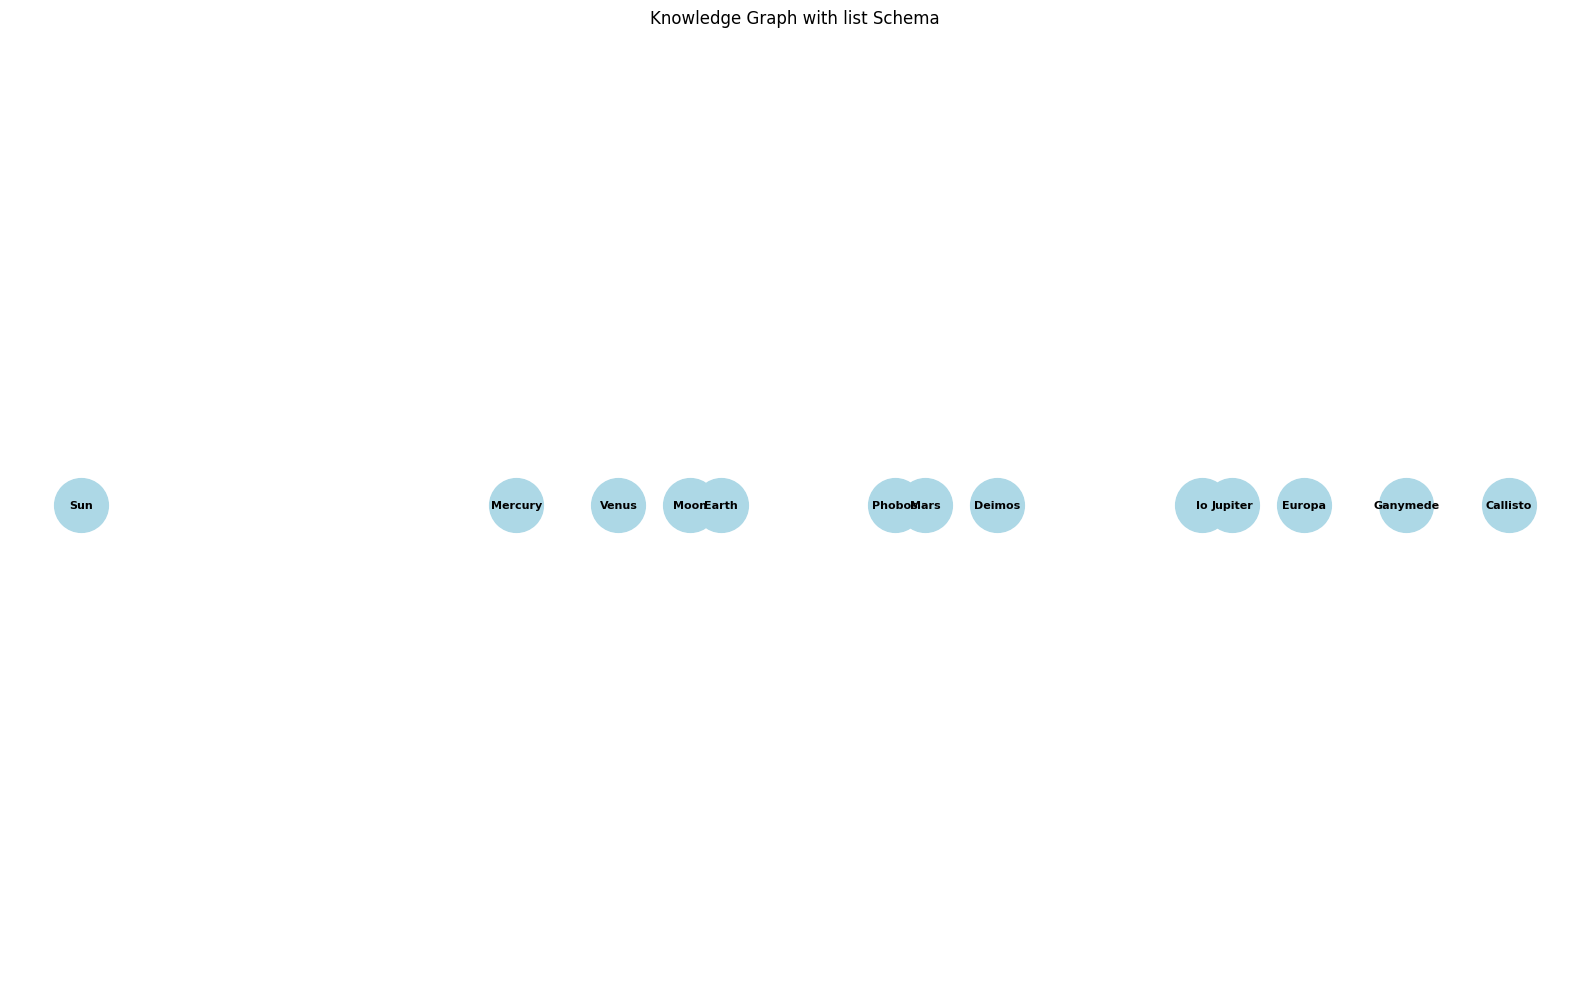

In [12]:
create_image_graph(graph_list_schema, title="Knowledge Graph with list Schema", path="figs/knowledge_graph_list_schema.png")
create_html_graph(graph_list_schema, path='html/knowledge_graph_list_schema.html')

### Prompt schema

Another approach we can take is to introduce a `graph_prompt` during `LLMGraphTransformer` initialization. With this approach we can declare in some form of natural language what the expected nodes and edges should be. We can, and possibly should, also provide examples about what relationships between nodes can come up, or provide natural language descriptions about specific constraints and specific rules.

In [13]:
# Create a ChatPromptTemplate for graph extraction
graph_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an expert Neo4j Cypher query generator.

TASK:
- Translate the user's natural language question into a Cypher query.

CONSTRAINTS:
- Use ONLY the schema provided below.
- Do NOT invent labels, relationship types, or properties.
- Do NOT explain the query.
- Output ONLY valid Cypher.
- If the question cannot be answered unambiguously using the schema, output:
  // CANNOT_ANSWER

GRAPH SCHEMA:
Node labels:
- Star {{id}}
- Planet {{id}}
- Moon {{id}}
- Atmosphere {{id}}
- Substance {{id}}
- MagneticFieldStrength {{id}}

Relationships:
- (Planet)-[:ORBITS]->(Star)
- (Moon)-[:ORBITS]->(Planet)
- (Planet)-[:HAS_ATMOSPHERE]->(Atmosphere)
- (Atmosphere)-[:COMPOSED_OF]->(Substance)
- (Planet)-[:HAS_MAGNETIC_FIELD]->(MagneticFieldStrength)
     
ALLOWED VALUES:
- MagneticField.id \\in {{"none", "weak", "strong"}}

QUERY RULES:
1. Always specify node labels.
2. Always specify relationship directions.
3. MagneticField nodes MUST be matched or merged by description
4. Use meaningful variable names.
5. Return only properties, not full nodes.
6. Use DISTINCT unless duplicates are required.
7. Use OPTIONAL MATCH if information may be missing.
8. Do not use APOC or procedures.

FAILURE CONDITIONS:
- If required entities, labels, or relationships are missing from the schema,
  output:
  // CANNOT_ANSWER

EXAMPLES:
Question:
Which planet orbits the Sun?

Cypher:
MATCH (planet:Planet)-[:ORBITS]->(star:Star {{id: "Sun"}})
RETURN DISTINCT planet.id

Question:
Which moon orbits planet Mars?

Cypher:
MATCH (moon:Moon)-[:ORBITS]->(planet:Planet {{id: "Mars"}})
RETURN DISTINCT moon.id

Question:
What substances compose the atmosphere of Mars?

Cypher:
MATCH (planet:Planet {{id: "Mars"}})
      -[:HAS_ATMOSPHERE]->(atm:Atmosphere)
      -[:COMPOSED_OF]->(substance:Substance)
RETURN DISTINCT substance.id

Question:
Does Jupiter have a magnetic field?

Cypher:
MATCH (planet:Planet {{id: "Jupiter"}})
      -[:HAS_MAGNETIC_FIELD]->(prop:MagneticFieldStrength)
RETURN DISTINCT prop.id
"""),
    ("human", "{input}")
])


In [14]:
prompt_schema = LLMGraphTransformer(
    llm=chat_model,
    prompt=graph_prompt,
)

graph_prompt_schema = prompt_schema.convert_to_graph_documents(documents)

### Prompt schema success

In this example we see that the model was very much helped by the introduction of a prompt that described the schema and was indeed able to capture the atmoshpere and magnetic field properties of planets and connect to them with edges.

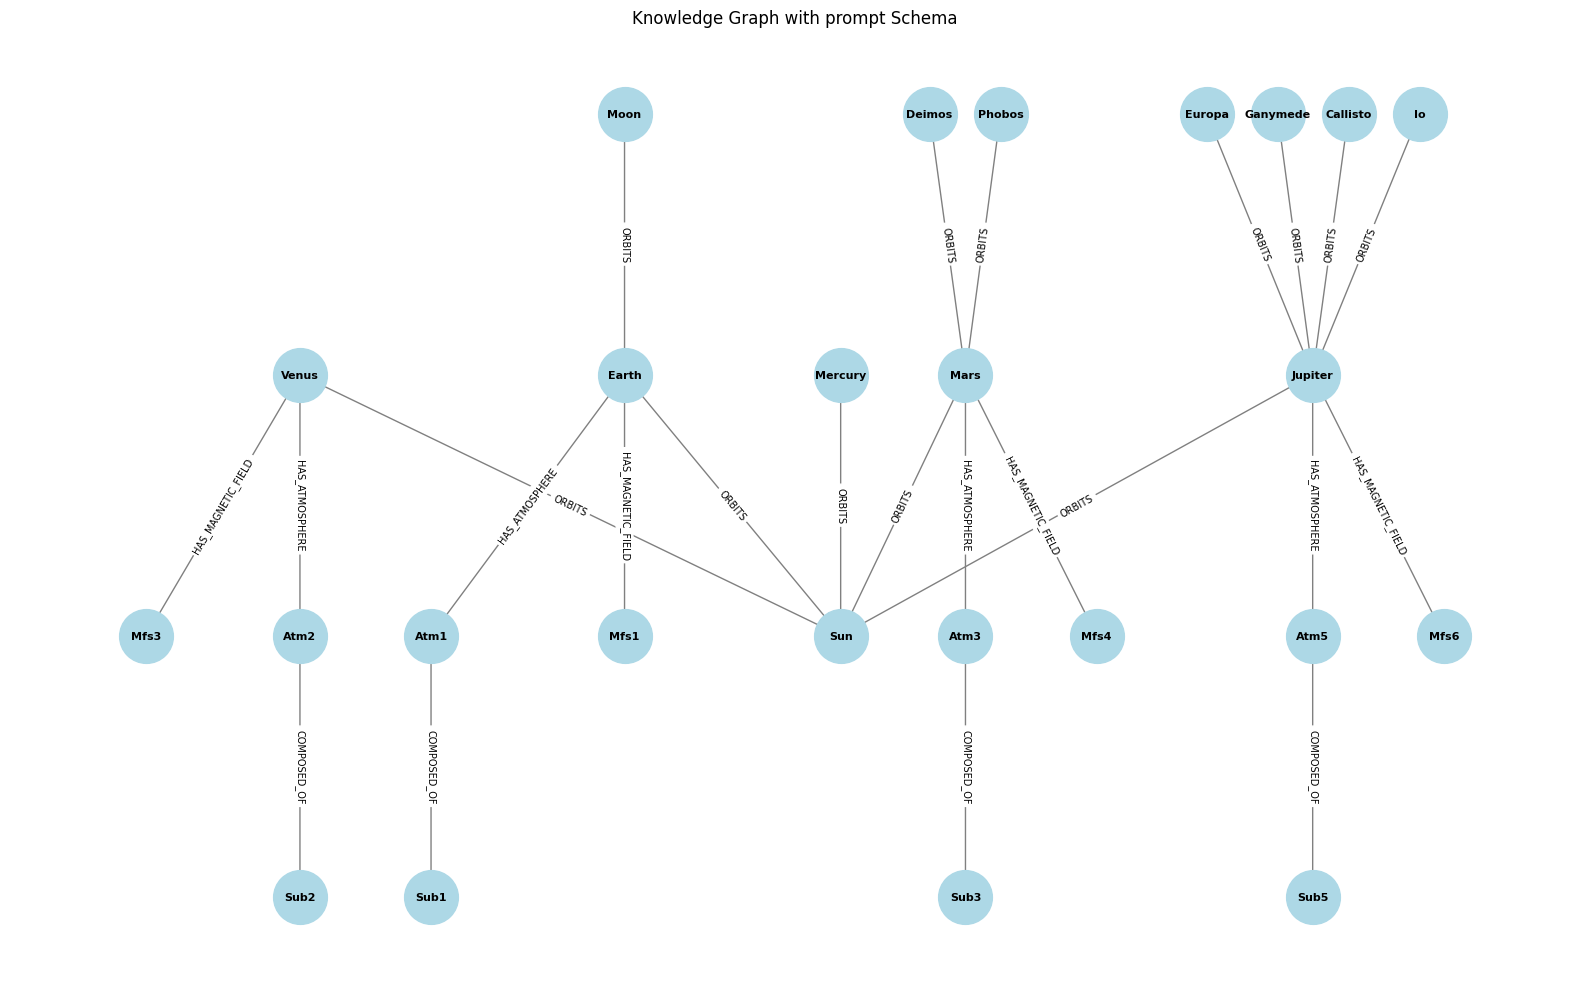

In [15]:
create_image_graph(graph_prompt_schema, title="Knowledge Graph with prompt Schema", path="figs/knowledge_graph_prompt_schema.png")
create_html_graph(graph_prompt_schema, path='html/knowledge_graph_prompt_schema.html')